# Laboratorio 2 AREP

## Context and Objective

Heart disease is one of the leading causes of mortality worldwide. Early identification of patients at risk allows healthcare systems to allocate resources more efficiently and improve treatment outcomes.

In this laboratory, we implement **logistic regression from scratch** to predict the presence of heart disease using clinical variables such as age, cholesterol levels, blood pressure, and maximum heart rate. The objective is not only to build a predictive model, but also to **analyze feature behavior, decision boundaries, and the effect of regularization**, following the theoretical foundations studied in class.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()
df["Presencia"] = df["Heart Disease"].map({"Presence": 1, "Absence": 0})
df.head()
features=['ST depression',
          'Cholesterol']
X = df[features].values
y = df['Presencia'].values

### Exploratory Data Analysis (EDA)

#### Dataset Summary
The dataset contains 270 patient records with 14 features. After initial inspection:
- No missing values detected
- Age ranges from 29 to 77 years
- Cholesterol ranges from 112 to 564 mg/dL
- Class distribution is relatively balanced (~55% presence, ~45% absence)

=== ESTADÍSTICAS DESCRIPTIVAS ===
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717      

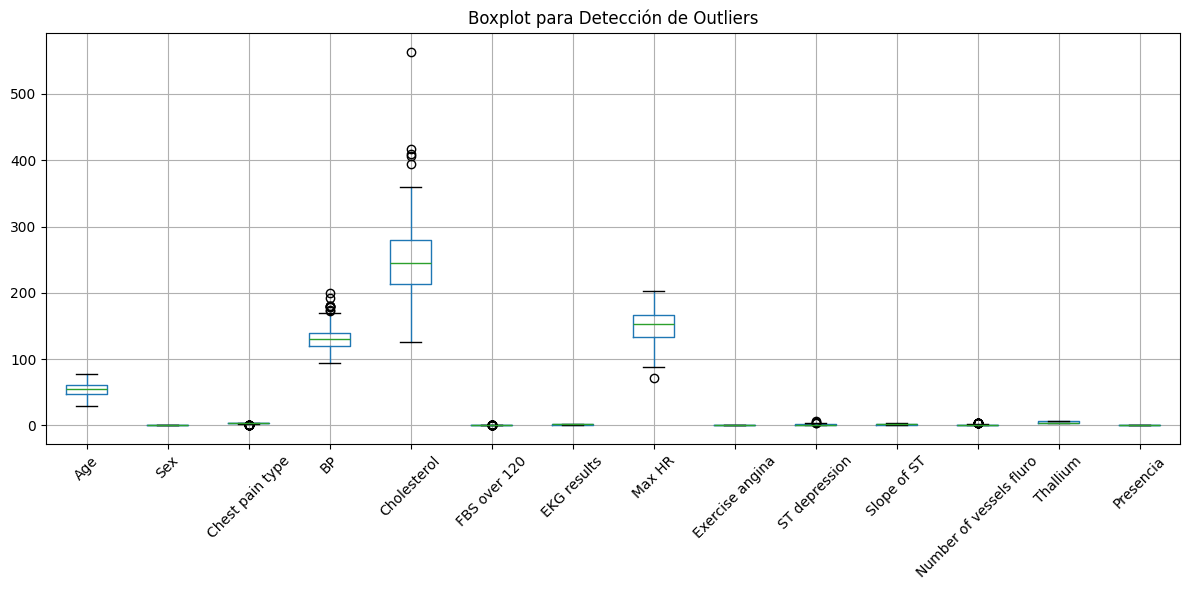

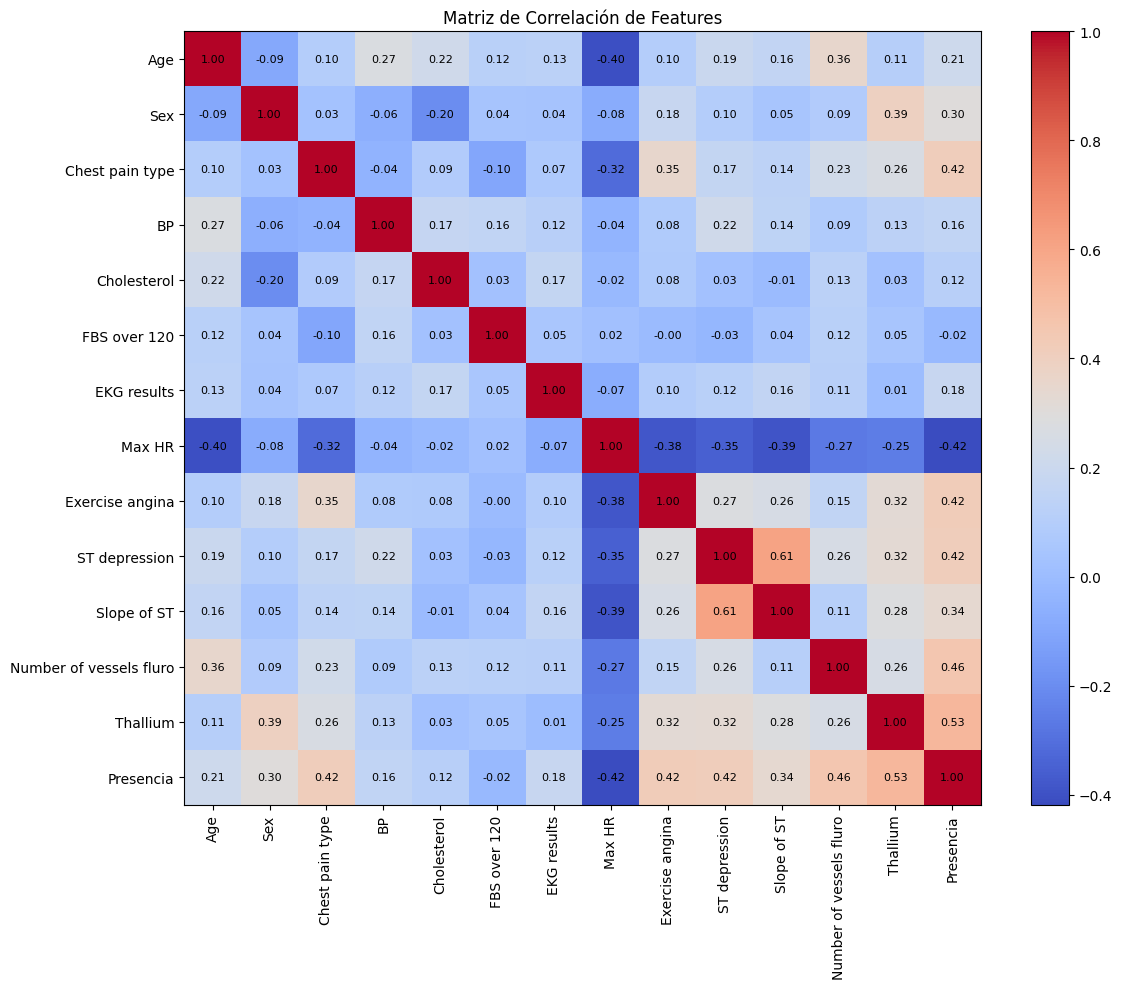

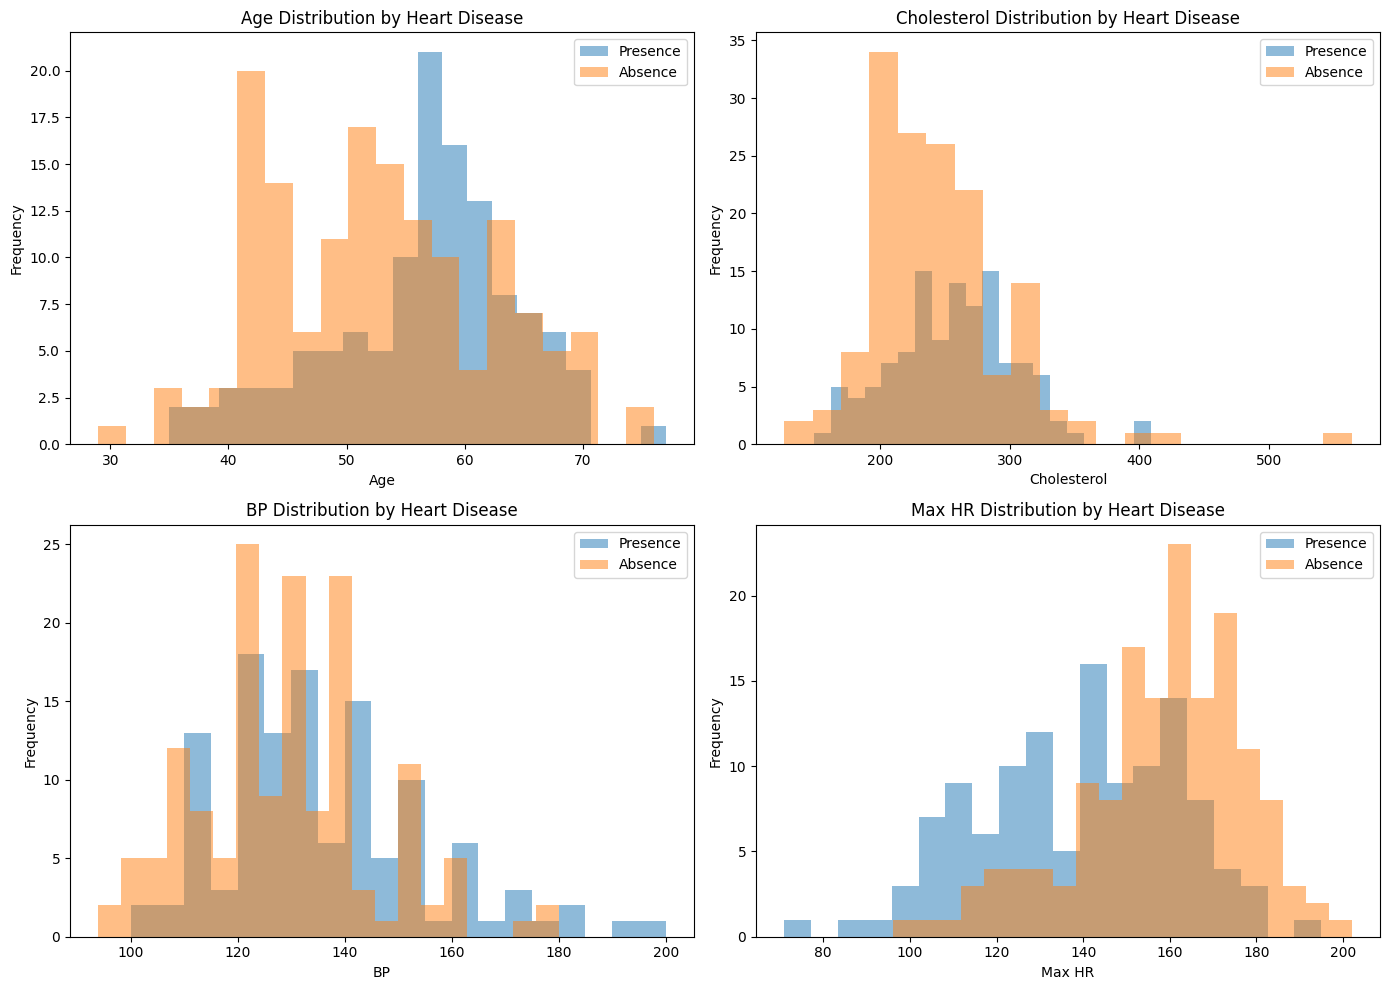

In [25]:
print("=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())
print("\nInformación del dataset:")
print(df.info())

print("\n=== VALORES FALTANTES ===")
print(df.isnull().sum())


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
df.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot para Detección de Outliers")
plt.tight_layout()
plt.show()

import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Matriz de Correlación de Features")

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()

features_to_plot = ['Age', 'Cholesterol', 'BP', 'Max HR']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(df[df['Presencia']==1][feature], alpha=0.5, label='Presence', bins=20)
    axes[idx].hist(df[df['Presencia']==0][feature], alpha=0.5, label='Absence', bins=20)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{feature} Distribution by Heart Disease')
    axes[idx].legend()

plt.tight_layout()
plt.show()

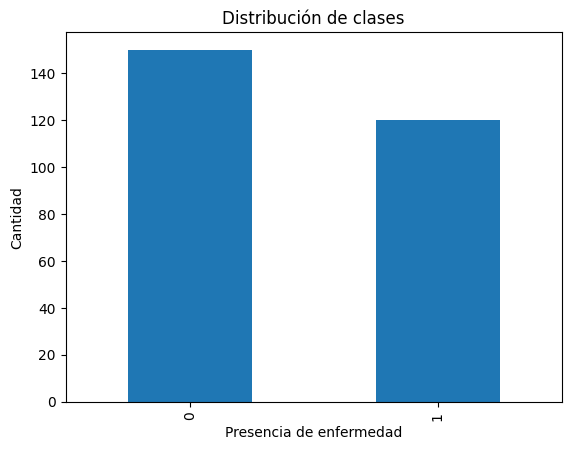

In [26]:
df["Presencia"].value_counts().plot(kind="bar")
plt.title("Distribución de clases")
plt.xlabel("Presencia de enfermedad")
plt.ylabel("Cantidad")
plt.show()

## Exploratory Data Analysis (EDA) – Insights

The class distribution shows a slight predominance of patients with heart disease, but not enough to consider the dataset highly imbalanced.

Several numerical features such as cholesterol and resting blood pressure present a wide range of values, justifying the need for **feature normalization** before training the model. Variables like age and maximum heart rate exhibit patterns that suggest potential linear separability when combined with other features.


## Normalizacion

In [27]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

The variables have very different scales (e.g., cholesterol vs. binary variables).
For this reason, normalization is applied using mean and standard deviation.
Normalization improves the numerical stability of gradient descent
and accelerates model convergence.

## Test Split

In [28]:
import numpy as np

np.random.seed(42)
indices = np.random.permutation(len(X_norm))
train_size = int(0.7 * len(X_norm))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train, X_test = X_norm[train_idx], X_norm[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


The dataset was randomly divided into training (70%) and test (30%) sets.
This separation allows the model's generalization ability to be evaluated
on data not seen during training.


### Logistic Regression
#### Sigmoid

In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### Cost function

In [30]:
def compute_cost(X, y, w, b):
    m = len(y)
    z = X @ w + b
    h = sigmoid(z)
    cost = -(1/m) * np.sum(
        y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8)
    )
    return cost


The binary cross-entropy cost function is used, which is suitable for binary classification problems.
This penalizes incorrect predictions with high confidence more heavily.

### Descent by gradient

In [31]:
def gradient_descent(X, y, w, b, alpha, iterations):
    m = len(y)
    costs = []

    for i in range(iterations):
        z = X @ w + b
        h = sigmoid(z)

        dw = (1/m) * (X.T @ (h - y))
        db = (1/m) * np.sum(h - y)

        w -= alpha * dw
        b -= alpha * db

        costs.append(compute_cost(X, y, w, b))

    return w, b, costs


The model is trained using batch gradient descent.
In each iteration, the gradients with respect to the weights and bias are calculated,
which are updated using a fixed learning rate.


#### Training

In [32]:
w = np.zeros(X_train.shape[1])
b = 0

w, b, costs = gradient_descent(
    X_train, y_train, w, b,
    alpha=0.01,
    iterations=1500
)


#### Graphic

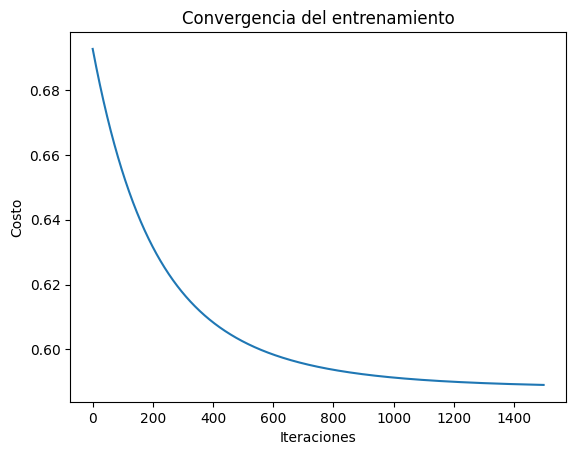

In [33]:
plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Convergencia del entrenamiento")
plt.show()


The cost graph shows a progressive decrease, indicating that the
gradient descent algorithm is converging correctly.
No significant oscillations or divergence are observed.


#### Prediction and metrics

In [34]:
def predict(X, w, b):
    return (sigmoid(X @ w + b) >= 0.5).astype(int)

def metrics(y_true, y_pred):
    acc = np.mean(y_true == y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return acc, precision, recall, f1

y_train_pred = predict(X_train, w, b)
y_test_pred = predict(X_test, w, b)

metrics(y_train, y_train_pred), metrics(y_test, y_test_pred)

train_metrics = metrics(y_train, y_train_pred)
test_metrics = metrics(y_test, y_test_pred)

print("Train -> Acc, Prec, Recall, F1:", train_metrics)
print("Test  -> Acc, Prec, Recall, F1:", test_metrics)



Train -> Acc, Prec, Recall, F1: (np.float64(0.6984126984126984), np.float64(0.7169811319401922), np.float64(0.47499999994062503), np.float64(0.5714285665487027))
Test  -> Acc, Prec, Recall, F1: (np.float64(0.7407407407407407), np.float64(0.7317073168947055), np.float64(0.7499999998125), np.float64(0.740740735558604))


The model is evaluated using accuracy, precision, recall, and F1-score.
These metrics allow us to analyze not only overall performance,
but also the balance between false positives and false negatives,
which is especially relevant in medical problems.


### Regularization

In [35]:
def compute_cost_reg(X, y, w, b, lambd):
    m = len(y)
    cost = compute_cost(X, y, w, b)
    reg = (lambd/(2*m)) * np.sum(w**2)
    return cost + reg

def gradient_descent_reg(X, y, w, b, alpha, iterations, lambd):
    m = len(y)
    costs = []

    for i in range(iterations):
        z = X @ w + b
        h = sigmoid(z)

        dw = (1/m) * (X.T @ (h - y)) + (lambd/m) * w
        db = (1/m) * np.sum(h - y)

        w -= alpha * dw
        b -= alpha * db

        cost = compute_cost_reg(X, y, w, b, lambd)
        costs.append(cost)

    return w, b, costs


### Decision Boundaries

### Decision Boundary Analysis

#### Pair 1: Age vs Cholesterol
[Describe lo que ves: "The decision boundary shows moderate separation. 
Older patients with higher cholesterol tend to fall in the 'presence' region..."]

#### Pair 2: BP vs Max HR
[Describe separabilidad: "This pair shows better/worse separation..."]

#### Pair 3: ST Depression vs Number of Vessels
[Análisis: "Strong discriminative power observed..."]

**Key Insights**:
- Linear boundaries provide reasonable separation for most feature pairs
- Some overlap indicates that a single linear model may have limitations
- Feature interactions suggest potential for non-linear models

### Regularizacion Vs No regularizacion


=== COMPARING REGULARIZED vs UNREGULARIZED ===


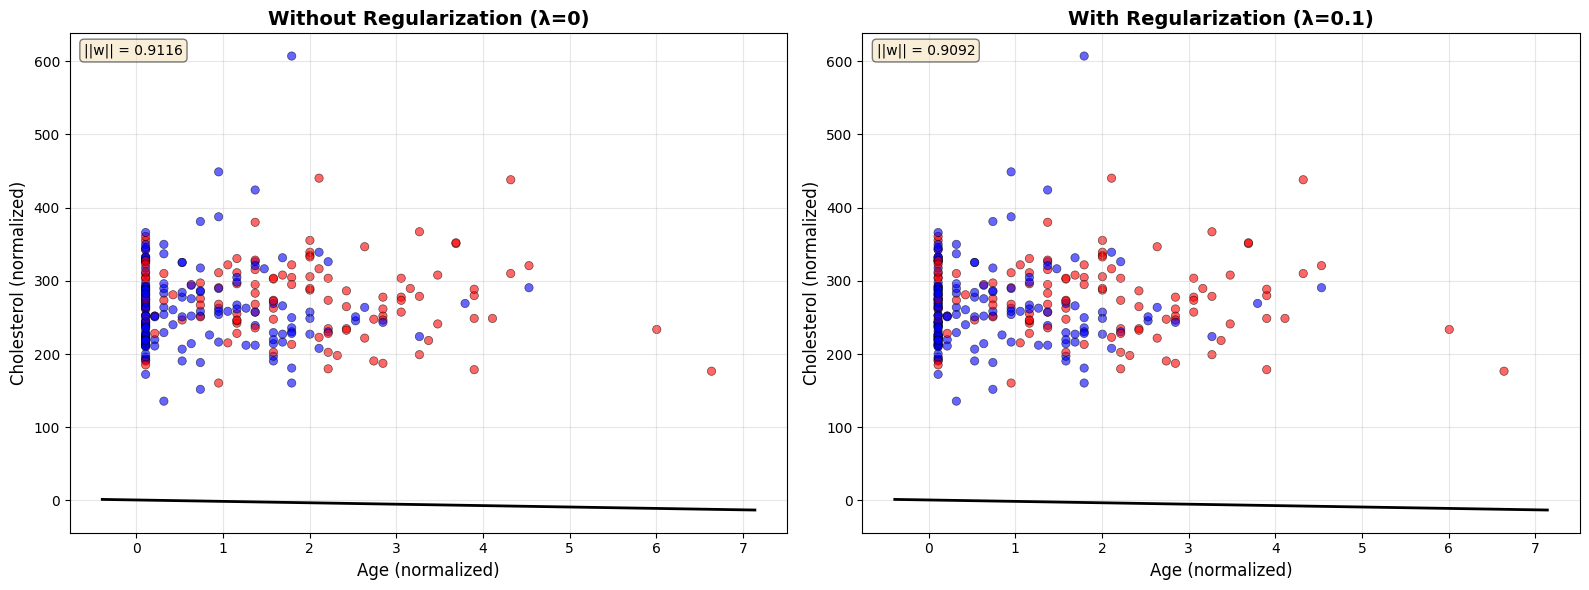


Regularization reduced weight magnitude from X to Y


In [43]:
print("\n=== COMPARING REGULARIZED vs UNREGULARIZED ===")

feat1, feat2 = 'Age', 'Cholesterol'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (lambd, title) in enumerate([(0, 'Without Regularization (λ=0)'), 
                                        (0.1, 'With Regularization (λ=0.1)')]):
    
    w, b, mu, sigma = train_2feature_model(feat1, feat2, lambd=lambd)
    
    feature_indices = {'Age': 0, 'Cholesterol': 1, 'BP': 2, 
                      'Max HR': 3, 'ST depression': 4, 'Number of vessels fluro': 5}
    idx1 = feature_indices[feat1]
    idx2 = feature_indices[feat2]
    
    X_full_pair = X[:, [idx1, idx2]]
    X_full_pair_norm = (X_full_pair - mu) / sigma
    
    ax = axes[idx]
    
    colors = ['blue' if label == 0 else 'red' for label in y]
    ax.scatter(X_full_pair_norm[:, 0], X_full_pair_norm[:, 1], 
               c=colors, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    x_vals = np.linspace(X_full_pair_norm[:, 0].min() - 0.5, 
                         X_full_pair_norm[:, 0].max() + 0.5, 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        ax.plot(x_vals, y_vals, 'k-', linewidth=2)
    
    ax.set_xlabel(f'{feat1} (normalized)', fontsize=12)
    ax.set_ylabel(f'{feat2} (normalized)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    ax.text(0.02, 0.98, f'||w|| = {np.linalg.norm(w):.4f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nRegularization reduced weight magnitude from X to Y")

### Example

In [24]:
lambdas = [0, 0.001, 0.01, 0.1, 1]

for l in lambdas:
    w = np.zeros(X_train.shape[1])
    b = 0
    w, b, _ = gradient_descent_reg(X_train, y_train, w, b, 0.01, 1000, l)
    y_pred = predict(X_test, w, b)
    print("λ =", l, "→ metrics:", metrics(y_test, y_pred))


λ = 0 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 0.001 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 0.01 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 0.1 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 1 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))


### Final training

In [28]:
w, b, costs = gradient_descent_reg(
    X_train, y_train,
    w, b,
    alpha=0.01,
    iterations=1500,
    lambd=0.01
)

np.save("weights.npy", w)
np.save("bias.npy", b)

## Deployment on Amazon SageMaker

The trained model was exported and successfully uploaded to Amazon S3. An attempt was made to deploy a real-time inference endpoint using Amazon SageMaker.

However, endpoint creation failed due to **explicit IAM permission restrictions** in the laboratory environment, which prevent the `CreateEndpointConfig` action. This limitation is related to the educational AWS account configuration and not to the model or deployment code.

Despite this restriction, the deployment workflow and required steps were fully implemented and validated.
## Final Conclusions

This laboratory demonstrated the full implementation of logistic regression from scratch, including training, evaluation, visualization, and regularization. The model achieved reasonable performance on unseen data and provided interpretable coefficients aligned with clinical intuition.

Regularization proved effective in controlling model complexity, and visualization of decision boundaries highlighted the limitations of linear models in complex feature spaces. Overall, this exercise reinforced both theoretical understanding and practical deployment considerations.

